# Week 2 - Polynomial Curve Fitting and Decision Theory

Learning contents:

1. Linear models
    - Linear function
    - Error function
    - Root meant square error
    - Optimization of Error function
    - Test the model
2. Regularization
    - Error function
    - Optimization
    - Test with regularization
3. Model Selection
    - Cross-validation
4. Bayesian curve fitting
    - Display results

## Description

In this exercise we will apply Linear Models for Polynomial Curve Fitting task.

You have to fill empty functions (with pass in body) to match their purpose.

1. You have to create a code for evaluation of a Linear Model, it's error functions and finding optimal weights with given error functions.
2. You need to add regularization to the optimization procedure.
3. You need to implement Cross-validation model selection technique.
4. You need to implement Bayesian curve fitting, computing phi and S matricies at first, then using them to compute mean and variance.

## Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import  exp

import seaborn as sns; sns.set(); sns.set_palette('bright')

## Generate Data

In [2]:
def target_func(x): return np.sin(2*np.pi*x)

def generate_data(size):
    rng = np.random.RandomState(26052605)
    x_train = rng.uniform(0., 1., size)
    y_train = target_func(x_train) + rng.normal(scale=0.1, size=size)
    x_test = np.linspace(0., 1., 100)
    y_test = target_func(x_test)
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = generate_data(10)

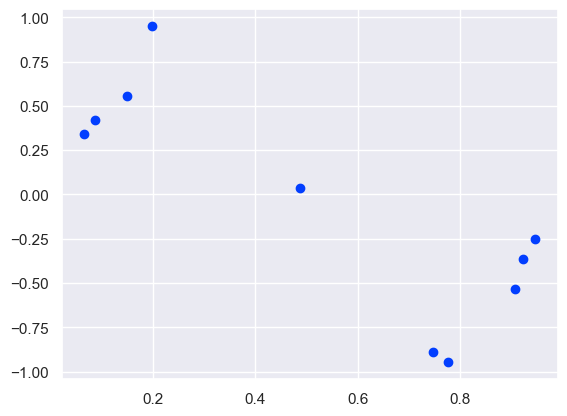

In [3]:
plt.scatter(x_train, y_train)

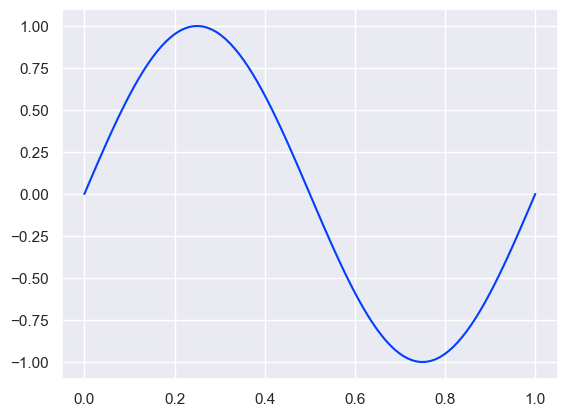

In [4]:
plt.plot(x_test, y_test, '-')

## 1) Linear models

### 1.1) Linear function

`linear` takes data point `x` and a list of `weights` as parameters 

In [5]:
def linear(x, weights):
    result = 0
    for i, weight in enumerate(weights):
        result += weight * x ** i
    return result

### 1.2) Error function

`err` is a sum-of-squares error function that takes `weights`, `inputs` and `targets` as parameters

In [6]:
def err(weights, inputs, targets):
    result = 0
    for inp, tar in zip(inputs, targets):
        result += (linear(inp, weights) - tar) ** 2
    return result / 2

### 1.3) Root meant square error

In [7]:
def erms(weights, inputs, targets):
    return (2*err(weights, inputs, targets) / len(inputs)) ** 0.5

### 1.4) Optimization of Error function

`optimial_weights` takes `inputs`, `targets`, and `M` (number of weights) as parameters and returns optimal weights for this data

In [8]:
def optimial_weights(inputs, targets, M):
    X = np.array([[inputs[j] ** i for j in range(len(inputs))] for i in range(M+1)])
    X_T = np.transpose(X)
    result = np.linalg.inv(X @ X_T) @ X @ np.array(targets)
    # result = np.matmul(np.matmul(np.linalg.inv(np.matmul(X, np.transpose(X))), X), np.array(targets))
    return result.tolist()

### 1.5) Test the model

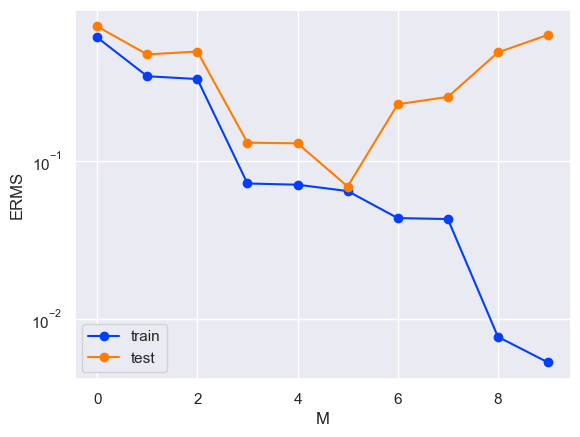

In [9]:
def test_all(start_M, end_M, x_train, y_train, x_test, y_test):
    
    results_train = []
    results_test = []
    all_weights = []
    
    for M in range(start_M, end_M + 1):
        weights = optimial_weights(x_train, y_train, M)
        all_weights.append(weights)
        error_train = erms(weights, x_train, y_train)
        error_test = erms(weights, x_test, y_test)
        results_train.append(error_train)
        results_test.append(error_test)
    return results_train, results_test, all_weights

r_tr, r_tt, all_weights = test_all(0, 9, x_train, y_train, x_test, y_test)


plt.plot(list(range(0, 10)), r_tr, '-o', label='train')
plt.plot(list(range(0, 10)), r_tt, '-o', label='test')
plt.xlabel('M')
plt.ylabel('ERMS')
plt.legend()
plt.yscale('log')

##### Weights table for different `M`

In [10]:
print(pd.DataFrame(all_weights))

          0           1            2             3             4  \
0 -0.067444         NaN          NaN           NaN           NaN   
1  0.674906   -1.403250          NaN           NaN           NaN   
2  0.870601   -2.937208     1.521622           NaN           NaN   
3 -0.348533   11.654727   -33.094539     22.088529           NaN   
4 -0.274931   10.447965   -27.877273     14.161034      3.897826   
5  0.052313    2.957062    24.077616   -126.364848    164.358999   
6  1.343704  -29.263452   282.780676  -1019.109729   1661.058884   
7  1.660039  -39.467231   401.669014  -1667.843416   3460.328956   
8 -2.484867  104.772720 -1468.032263  10146.471933 -36848.376658   
9 -1.475252   60.012522  -693.255271   3299.356893  -2861.903563   

              5             6              7             8             9  
0           NaN           NaN            NaN           NaN           NaN  
1           NaN           NaN            NaN           NaN           NaN  
2           NaN           

##### Estimated curve for `M=9` (same as the amount of data points) 

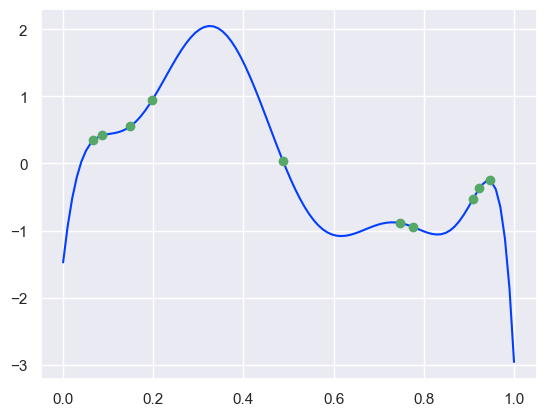

In [11]:
plt.plot(x_test, list(map(lambda x: linear(x, optimial_weights(x_train, y_train, 9)), x_test)), '-')
plt.plot(x_train, y_train, 'og')

## 2) Regularization

### 2.1) Error function

`err_regularization` takes `weights`, `inputs`, `targets` and `l` (regularization term) and computes sum-of-squares error with weights regularization

In [12]:
import functools

def err_regularization(weights, inputs, targets, l):
    result = 0
    
    w = l/2 * functools.reduce(lambda acc, cur: acc + cur ** 2, weights) 
    
    for inp, tar in zip(inputs, targets):
        result += (linear(inp, weights) - tar) ** 2 + w
    
    return result / 2

`erms_regularization` is a regularization version of a root mean squares error

In [13]:
def erms_regularization(weights, inputs, targets, l):
    return (2*err_regularization(weights, inputs, targets, l) / len(inputs)) ** 0.5

### 2.2) Optimization

`optimial_weights_regularization` takes `inputs`, `targets`, `M` (number of weights) and `l` (regularization term)  as parameters and returns optimal weights (with regularization) for this data

In [14]:
def optimial_weights_regularization(inputs, targets, M, l):
    X = np.array([[inputs[j] ** i for j in range(len(inputs))] for i in range(M+1)])
    X_T = np.transpose(X)
    result = np.linalg.inv(X @ X_T + l * np.identity(M+1)) @ X @ np.array(targets)
    return result.tolist()

### 2.3) Test with regularization

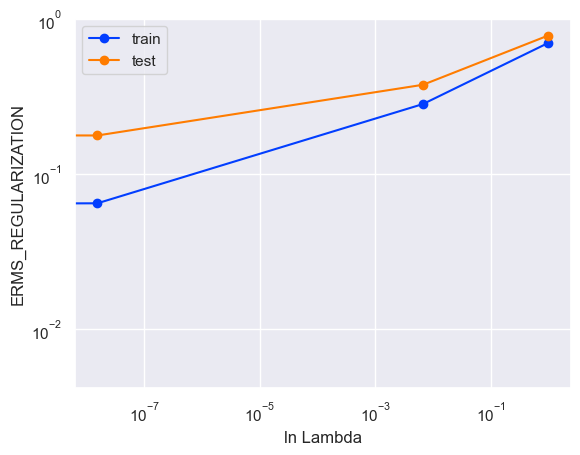

In [15]:
def test_all_regularization(ls, M, x_train, y_train, x_test, y_test):
    
    results_train = []
    results_test = []
    all_weights = []
    
    for l in ls:
        weights = optimial_weights_regularization(x_train, y_train, M, l)
        all_weights.append(weights)
        error_train = erms_regularization(weights, x_train, y_train, l)
        error_test = erms_regularization(weights, x_test, y_test, l)
        results_train.append(error_train)
        results_test.append(error_test)
    return results_train, results_test, all_weights

ls = [0, exp(-18), exp(-5), exp(0)]

r_tr_r, r_tt_r, all_weights_r = test_all_regularization(ls, 9, x_train, y_train, x_test, y_test)

plt.plot(ls, r_tr_r, '-o', label='train')
plt.plot(ls, r_tt_r, '-o', label='test')
plt.xlabel('ln Lambda')
plt.ylabel('ERMS_REGULARIZATION')
plt.legend()
plt.yscale('log')
plt.xscale('log')

##### Weights for `M=9` with regularization terms `0`, `exp(-18)`, `exp(-5)`, `exp(0)`

In [16]:
print(pd.DataFrame(np.transpose(all_weights_r)))

               0           1         2         3
0      -1.475252    0.699011  0.503543  0.328543
1      60.012522  -11.795682  0.743539 -0.389393
2    -693.255271  121.043846 -2.425527 -0.353466
3    3299.356893 -335.150184 -1.908122 -0.232935
4   -2861.903563  217.987072 -0.795824 -0.127092
5  -24427.504354  178.622532  0.106829 -0.046211
6   86645.236646  -87.722836  0.719266  0.013218
7 -122608.516466 -148.839177  1.096707  0.055948
8   81993.729168  -12.387887  1.302133  0.085993
9  -21408.641285   78.207420  1.385740  0.106489


In [17]:
def plot_by_lambda(l):
    plt.plot(x_test, y_test, '-m')
    plt.plot(x_test, list(map(lambda x: linear(x, optimial_weights_regularization(x_train, y_train, 9, l)), x_test)), '-')
    plt.plot(x_train, y_train, 'og')

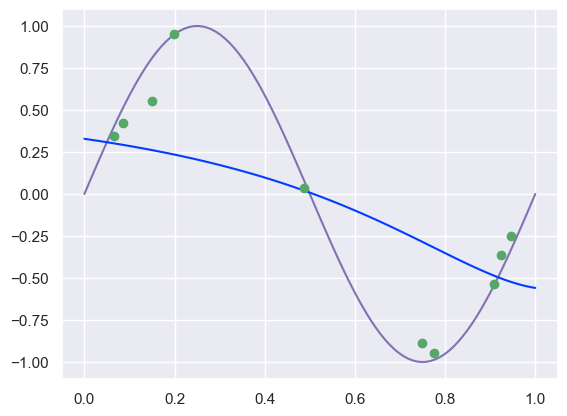

In [18]:
plot_by_lambda(exp(0))

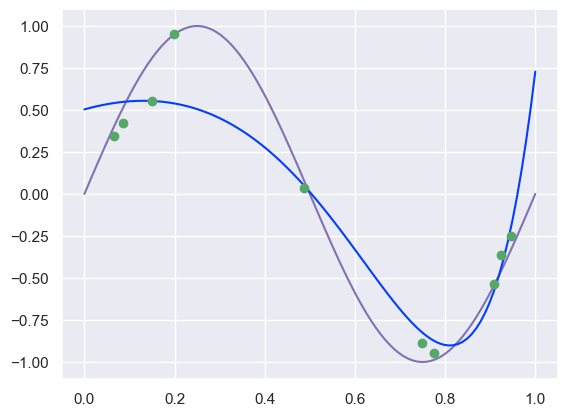

In [19]:
plot_by_lambda(exp(-5))

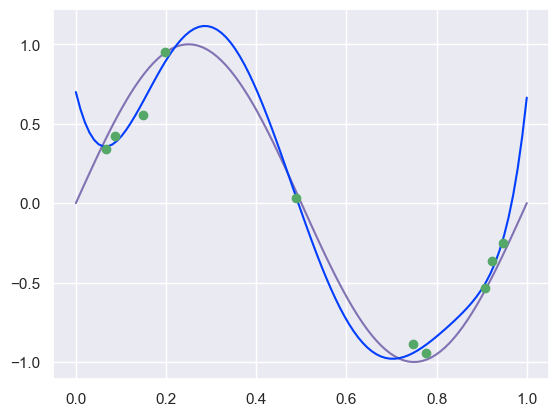

In [20]:
plot_by_lambda(exp(-18))

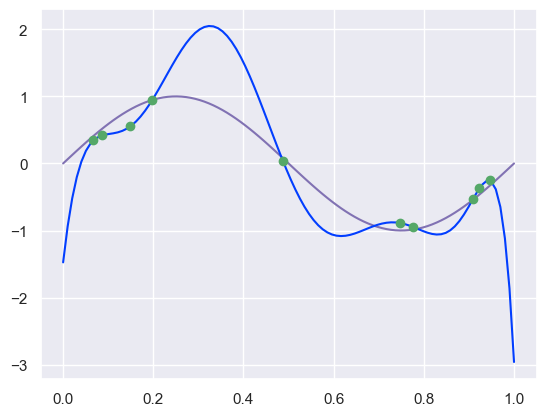

In [21]:
plot_by_lambda(0)

## 3) Model Selection

### 3.1) Cross-validation

`create_cross_validation_sets` takes `S` (number of sets) and data points `x_train`, `y_train` as parameters and returns array of sets in form `[x_sub_train, y_sub_train, x_validation, y_validation]` each

In [22]:
def create_cross_validation_sets(S, x_train, y_train):
    result = []
    
    size = len(x_train) // S
    
    for i in range(S):
        x_validation = x_train[size * i:size * (i + 1) + 1]
        y_validation = y_train[size * i:size * (i + 1) + 1]
        x_sub_train = x_train[size * (i + 1) + 1:] if i == 0 else np.concatenate((x_train[:size * i], x_train[size * (i + 1) + 1:]))
        y_sub_train = y_train[size * (i + 1) + 1:] if i == 0 else np.concatenate((y_train[:size * i], y_train[size * (i + 1) + 1:]))
        
        result.append([x_sub_train, y_sub_train, x_validation, y_validation])
    
    return result

`best_model` takes `start_M`, `end_M` (low and high limits to search for `M`), `ls` (list of regularization terms) and `sets` (cross-validation sets) and should return `(top_M, top_l, top_result_test)` with `M`, `l` and result for the best model

M = 5 lambda = 0 erms = 0.21365393203052596


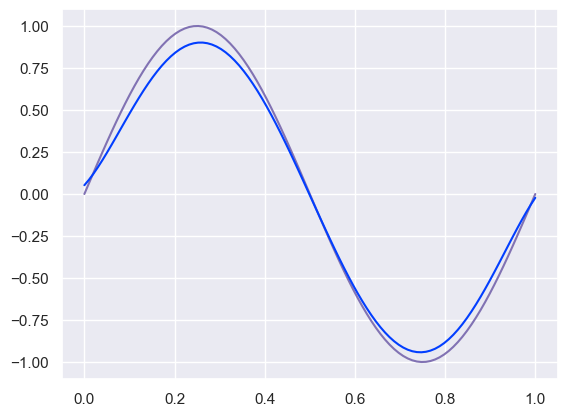

In [23]:
def best_model(start_M, end_M, ls, sets):
    
    top_M = -1
    top_l = -1
    top_result_test = -1
    
    for M in range(start_M, end_M + 1):
        
        all_results_test = []
        
        for x_train, y_train, x_test, y_test in sets:
            _, results_test, _ = test_all_regularization(ls, M, x_train, y_train, x_test, y_test)
            
            for i, r in enumerate(results_test):
                if len(all_results_test) <= i:
                    all_results_test.append(r)
                else:
                    all_results_test[i] += r / len(sets)

        for i, result_test in enumerate(all_results_test):
            if (top_result_test == -1) or result_test < top_result_test:
                top_result_test = result_test
                top_M = M
                top_l = ls[i]
    
    return top_M, top_l, top_result_test


x_cross_train, y_cross_train, _, _ = generate_data(100) 

M, l, r = best_model(0, 9, [0, exp(-18), exp(-5), exp(0)], create_cross_validation_sets(10, x_cross_train, y_cross_train))
print('M =', M, 'lambda =', l, 'erms =', r)

plt.plot(x_test, y_test, '-m')
plt.plot(x_test, list(map(lambda x: linear(x, optimial_weights_regularization(x_train, y_train, M, l)), x_test)), '-')

## 4) Bayesian curve fitting

`phi` takes `x` (data point) and `M` (number of weights) as arguments and returns a vector of powers of `x` from `0` to `M`

In [24]:
def phi(x, M):
    result = []
    
    for i in range(M + 1):
        result.append(x ** i)
    
    return np.array(result).reshape(-1, 1)

`S` takes `alpha`, `beta`, `x` (all data points), and `M` as arguments and returns a matrix `S` that is used to compute `mean` and `variance`

In [25]:
def S(alpha, beta, x, M):
    I = np.identity(M + 1)
    
    sum = 0
    for x_i in x:
        phi_value = phi(x_i, M) 
        sum += phi_value @ np.transpose(phi_value)
    
    result = alpha * I + beta * sum
    return np.linalg.inv(result)

`mean` takes `alpha`, `beta`, `x_star` (new point), `x` (all data points), `t` (target values), and `M` and computes mean for the Gaussian distribution

In [26]:
def mean(alpha, beta, x_star, x, t, M):
    sum = 0
    
    for x_i, t_i in zip(x, t):
        sum += phi(x_i, M) * t_i
    result = beta * (np.transpose(phi(x_star, M)) @ S(alpha, beta, x, M) @ sum)
    return result.reshape(1)[0]

`variance` takes `alpha`, `beta`, `x_star` (new point), `x` (all data points), `t` (target values), and `M` and computes variance for the Gaussian variance

In [27]:
def variance(alpha, beta, x_star, x, t, M):
    phi_value = phi(x_star, M)
    result = (1/beta) * (np.transpose(phi_value) @ S(alpha, beta, x, M) @ phi_value)
    return result.reshape(1)[0]

### 4.1) Display results

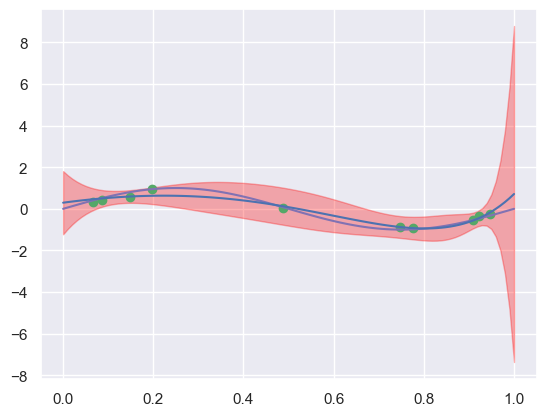

In [28]:
alpha = 0.001
beta = 0.91
M = 9

means = np.array(list(map(lambda x: mean(alpha, beta, x, x_train, y_train, M), x_test)))
variances = np.array(list(map(lambda x: variance(alpha, beta, x, x_train, y_train, M), x_test)))

plt.plot(x_train, y_train, 'og')
plt.plot(x_test, y_test, '-m')
plt.plot(x_test, means, '-b')
plt.fill_between(x_test, means + variances, means - variances, color='red', alpha=0.3)